In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [95]:
path = 'Data/Variants/SIR/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/SIR_Origin/*.csv'
dic_SIRs = Load_files.load_files(path, -17, -15)
data = dic_files['대구']
data

,stdDay,Susceptible,22D_Infected,22D_Recovered,22D_Dead,22D_alpha,22D_beta,22D_gamma,23A_Infected,23A_Recovered,23A_Dead,23A_alpha,23A_beta,23A_gamma
0,2022-12-19,1154500,7646.89,28392.09,32.73,0.470884,0.191027,0.000145,9.73,0.00,0.00,7.709827,0.000000,0.000000
1,2022-12-20,1150875,7925.02,29852.85,33.84,0.454658,0.172557,0.000233,45.98,0.00,0.00,1.632581,0.000000,0.000000
2,2022-12-21,1147259,8291.33,31220.37,35.69,0.385427,0.137623,0.000134,82.14,0.00,0.00,0.810531,0.000000,0.000000
3,2022-12-22,1144062,8683.70,32361.45,36.80,0.306706,0.122074,0.000170,114.11,0.00,0.00,0.486252,0.000000,0.000000
4,2022-12-23,1141405,8897.53,33421.50,38.28,0.319341,0.127748,0.000125,140.68,0.00,0.00,0.420776,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-04-30,1031603,503.31,104434.19,135.79,0.106662,0.063420,0.000000,1695.36,9178.20,10.14,0.106662,0.063420,0.000000
133,2023-05-01,1031481,494.57,104466.11,135.79,0.427119,0.164426,0.000384,1665.92,9285.72,10.14,0.427119,0.164426,0.000384
134,2023-05-02,1031001,504.26,104547.43,135.98,0.405137,0.161266,0.000377,1698.56,9559.64,10.78,0.405137,0.161266,0.000377
135,2023-05-03,1030537,510.91,104628.75,136.17,0.505227,0.147267,0.000000,1720.96,9833.56,11.42,0.505227,0.147267,0.000000


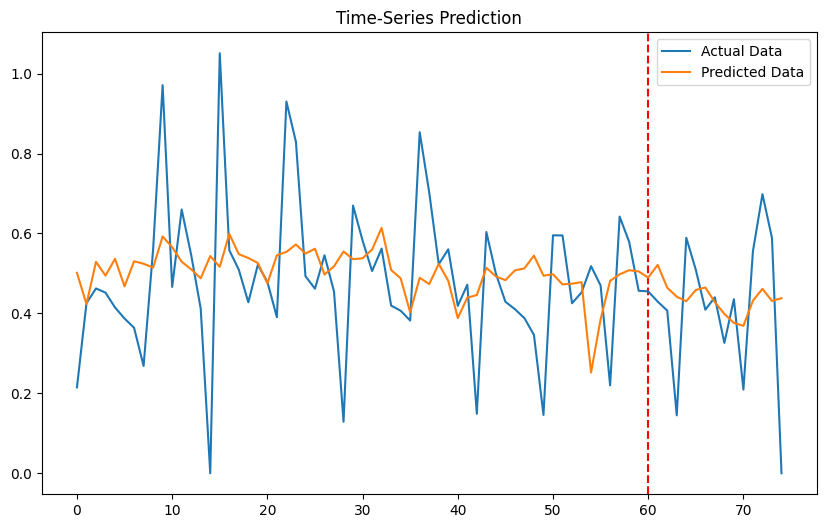

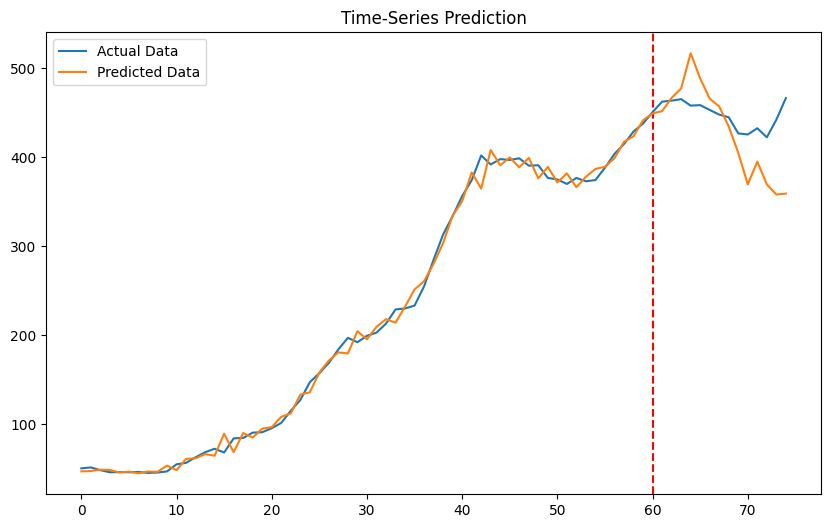

In [159]:
city = '세종'

data = dic_files[city]

df = Prepare_df.processing(data, 'stdDay', '23A_alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

lr = 1e-4
patience = 10
num_layers = 2
batch_size = 64
hidden_size = 16
dropout = 0.25

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 48, 60, 14, batch_size, 'mtm')

model = BiGRU_encoder_decoder(input_size = input_size,
                            hidden_size = hidden_size,
                              num_layers = num_layers, 
                              dropout = dropout, 
                              device = device).to(device)

optimizer = Adam(model.parameters(), lr = lr)

loss_list, model, epoch = Trainer.Many_to_Many(train_loader, 
                                               test_loader, 
                                               model, 
                                               criterion, 
                                               optimizer, 
                                               num_epochs, 
                                               patience,
                                               14,
                                               device)

label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(model, df, x_ss, y_ms, 14, 0.5, device)

df_predicted = data[['stdDay']].copy()

df_predicted['23A_alpha'] = data['23A_alpha']

df_predicted['predicted_23A_alpha'] = 0
df_predicted.iloc[-1*len(all_predicted):, -1] = all_predicted

df_predicted['23A_Infected'] = data['23A_Infected']

df_predicted['predicted_23A_Infected'] = 0
df_predicted['predicted_23A_Infected'] = (data['23A_Infected'].shift().fillna(0) 
                                              * (1 + data['23A_alpha']*data['Susceptible']/dic_SIRs[city].iloc[0, 2] 
                                                - data['23A_beta'] - data['23A_gamma']))

for i in range(len(df_predicted)-13, len(df_predicted)):

    df_predicted.iloc[i, -1] = (df_predicted.iloc[i-1, -1]
                                  * (1 + df_predicted.iloc[i-1, 2]*data.iloc[i-1, 1]/dic_SIRs[city].iloc[0, 2]
                                    - data.iloc[i-1, 6] - data.iloc[i-1, 7]))

df_predicted = df_predicted[62:].reset_index(drop = True)
actual_Infected = df_predicted['23A_Infected']
predicted_Infected = df_predicted['predicted_23A_Infected']

plotting(df_predicted['23A_alpha'], df_predicted['predicted_23A_alpha'], 60)
plotting(df_predicted['23A_Infected'], df_predicted['predicted_23A_Infected'], 60)

df_predicted.to_csv(f'Capstone/SIR_23A_{city}.csv')

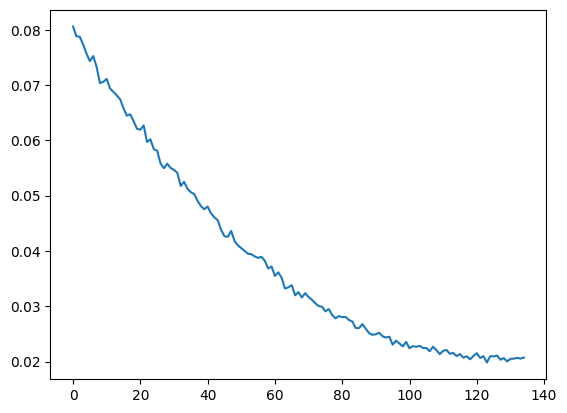

In [160]:
plt.plot(loss_list)

In [125]:
df_predicted.tail(20)

,stdDay,23A_alpha,predicted_23A_alpha,23A_Infected,predicted_23A_Infected
55,2023-04-15,0.327835,0.345500,1329.32,1326.190280
56,2023-04-16,0.112125,0.331086,1371.44,1327.148795
57,2023-04-17,0.433490,0.315824,1369.20,1417.435125
58,2023-04-18,0.506703,0.441660,1415.12,1438.554017
59,2023-04-19,0.414882,0.382129,1486.80,1463.090169
60,2023-04-20,0.413828,0.353256,1537.20,1553.421639
61,2023-04-21,0.399386,0.360349,1606.08,1599.374059
62,2023-04-22,0.358089,0.357294,1671.04,1636.591272
63,2023-04-23,0.139521,0.349435,1742.16,1705.673307
64,2023-04-24,0.467439,0.347530,1781.28,1901.410589


In [126]:
dic_SIRs[city]

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,경남,3311631,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,경남,3311631,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,경남,3311631,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,경남,3311631,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,경남,3311631,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1214,2023-05-20,경남,1435921,13871,1981,1859858,0.115222,0.134453,0.000072
1215,2023-05-21,경남,1435228,12698,1982,1861723,0.052697,0.031029,0.000000
1216,2023-05-22,경남,1434938,12594,1982,1862117,0.213487,0.084167,0.000079
1217,2023-05-23,경남,1433773,12698,1983,1863177,0.209182,0.087494,0.000079
